In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout

In [6]:
class RestaurantReviewClassifier:
    def __init__(self, max_words=5000, max_len=100):
        self.max_words = max_words
        self.max_len = max_len
        self.tokenizer = Tokenizer(num_words=max_words)
        self.label_encoders = {
            'food': LabelEncoder(),
            'service': LabelEncoder(),
            'atmosphere': LabelEncoder()
        }

    def clean_text(self, text):
        """Convert to string and handle NaN values"""
        if pd.isna(text):
            return ''
        return str(text)

    def preprocess_data(self, df):
        print("Initial data shape:", df.shape)

        # Clean text data
        df['text'] = df['text'].apply(self.clean_text)

        # Remove empty texts
        df = df[df['text'].str.len() > 0].copy()
        print("Data shape after cleaning:", df.shape)

        # Prepare text data
        self.tokenizer.fit_on_texts(df['text'])
        X = self.tokenizer.texts_to_sequences(df['text'])
        X = pad_sequences(X, maxlen=self.max_len)

        # Prepare label data
        y = []
        label_arrays = []

        for category in ['food', 'service', 'atmosphere']:
            # Fill NaN with 'None'
            df[category] = df[category].fillna('None')
            df[category] = df[category].astype(str)

            # Encode labels
            label_array = self.label_encoders[category].fit_transform(df[category])
            label_arrays.append(label_array)

        # Stack arrays vertically
        y = np.column_stack(label_arrays)
        print("X shape:", X.shape)
        print("y shape:", y.shape)

        return X, y

    def create_model(self, num_words, num_labels_dict):
        # Input layer
        input_layer = Input(shape=(self.max_len,))
    
        # Embedding layer
        embedding = Embedding(num_words, 128, input_length=self.max_len)(input_layer)
    
        # LSTM layers
        lstm_layer = LSTM(64, return_sequences=True)(embedding)  # Keep sequence
        lstm_layer = LSTM(64, return_sequences=True)(lstm_layer)  # Keep sequence
        lstm_layer = LSTM(32, return_sequences=False)(lstm_layer)  # Output fixed vector
    
        # Dropout for regularization
        dropout = Dropout(0.5)(lstm_layer)
    
        # Output layers for each category
        outputs = []
        for category in ['food', 'service', 'atmosphere']:
            output = Dense(num_labels_dict[category], activation='softmax',
                           name=f'{category}_output')(dropout)
            outputs.append(output)
    
        # Create model
        model = Model(inputs=input_layer, outputs=outputs)
    
        # Compile model
        losses = {f'{category}_output': 'sparse_categorical_crossentropy'
                  for category in ['food', 'service', 'atmosphere']}
        metrics = {f'{category}_output': 'accuracy'
                   for category in ['food', 'service', 'atmosphere']}
    
        model.compile(optimizer='adam', loss=losses, metrics=metrics)
    
        return model

    def train(self, df, epochs=50, batch_size=32):
        print("Starting data preprocessing...")
        X, y = self.preprocess_data(df)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Get number of unique labels for each category
        num_labels = {
            category: len(self.label_encoders[category].classes_)
            for category in ['food', 'service', 'atmosphere']
        }
        print("Number of labels per category:", num_labels)

        # Create and train model
        print("Creating model...")
        model = self.create_model(self.max_words, num_labels)

        # Prepare training data format
        y_train_dict = {
            f'{category}_output': y_train[:, i]
            for i, category in enumerate(['food', 'service', 'atmosphere'])
        }
        y_test_dict = {
            f'{category}_output': y_test[:, i]
            for i, category in enumerate(['food', 'service', 'atmosphere'])
        }

        print("Starting training...")
        history = model.fit(
            X_train,
            y_train_dict,
            validation_data=(X_test, y_test_dict),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

        return model, history

    def predict(self, model, text):
        # Preprocess input text
        cleaned_text = self.clean_text(text)
        seq = self.tokenizer.texts_to_sequences([cleaned_text])
        padded = pad_sequences(seq, maxlen=self.max_len)

        # Predict
        predictions = model.predict(padded)

        # Decode predictions
        results = {}
        for i, category in enumerate(['food', 'service', 'atmosphere']):
            pred_index = np.argmax(predictions[i][0])
            results[category] = self.label_encoders[category].classes_[pred_index]

        return results

In [7]:
    # Load data
print("Loading data...")
df = pd.read_csv('../raw_data/cleansed_reviews.csv')
print(f"Loaded {len(df)} reviews")

# Print data info
print("\nData Info:")
print(df[['text', 'food', 'service', 'atmosphere']].info())
print("\nSample data:")
print(df[['text', 'food', 'service', 'atmosphere']].head())

# Initialize classifier
classifier = RestaurantReviewClassifier()

# Train model
model, history = classifier.train(df)

# Example prediction
sample_review = "The food was amazing, but the service was slow"
prediction = classifier.predict(model, sample_review)
print("\nSample prediction:", prediction)

Loading data...
Loaded 3092 reviews

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3092 entries, 0 to 3091
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        3069 non-null   object
 1   food        2785 non-null   object
 2   service     1932 non-null   object
 3   atmosphere  1409 non-null   object
dtypes: object(4)
memory usage: 96.8+ KB
None

Sample data:
                                                text      food   service  \
0  nice authentic polish cuisine served staff att...  Positive  Positive   
1  wonderful traditional place taste true polish ...  Positive       NaN   
2  polish american hide happy tears away server f...  Positive  Positive   
3  mixed feelings place service less attentive ex...       NaN  Negative   
4  traditional zurek soup local polish beer match...  Positive  Positive   

  atmosphere  
0        NaN  
1   Positive  
2   Positive  
3        NaN  
4   Positive  

/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - atmosphere_output_accuracy: 0.4037 - atmosphere_output_loss: 1.2210 - food_output_accuracy: 0.2393 - food_output_loss: 1.1341 - loss: 3.2979 - service_output_accuracy: 0.3666 - service_output_loss: 0.9428 - val_atmosphere_output_accuracy: 0.4446 - val_atmosphere_output_loss: 0.9573 - val_food_output_accuracy: 0.4121 - val_food_output_loss: 0.8228 - val_loss: 2.4252 - val_service_output_accuracy: 0.3534 - val_service_output_loss: 0.6673
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - atmosphere_output_accuracy: 0.4811 - atmosphere_output_loss: 0.9869 - food_output_accuracy: 0.4831 - food_output_loss: 0.8593 - loss: 2.5244 - service_output_accuracy: 0.3747 - service_output_loss: 0.6782 - val_atmosphere_output_accuracy: 0.5603 - val_atmosphere_output_loss: 0.9106 - val_food_output_accuracy: 0.3664 - val_food_output_loss: 0.7945 - val_loss: 2.3267 - val_service_output_accuracy: 0.3534 - val_service_output_loss: 0.6431
Epoch 3/50
77/77 ━━━━━━━━

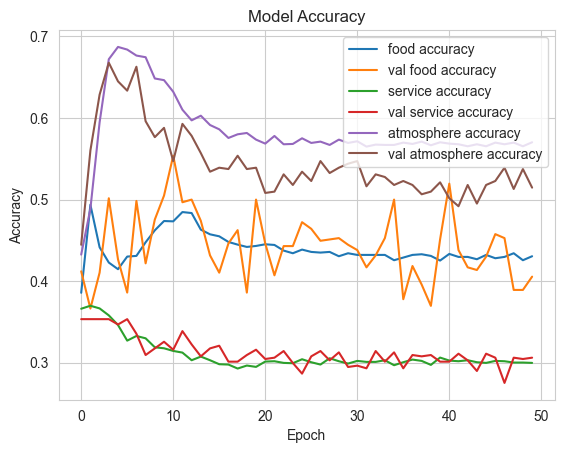

In [8]:
# plot training history
import matplotlib.pyplot as plt

def plot_history(history):
    for category in ['food', 'service', 'atmosphere']:
        plt.plot(history.history[f'{category}_output_accuracy'], label=f'{category} accuracy')
        plt.plot(history.history[f'val_{category}_output_accuracy'], label=f'val {category} accuracy')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
plot_history(history)

In [9]:
# Save model
model.save('../models/restaurant_review_classifier.h5')